<font color="#138D75">**NERO Winter School training**</font> <br>
**Copyright:** (c) 2025 EUMETSAT <br>
**License:** GPL-3.0-or-later <br>
**Authors:** Andrea Meraner (EUMETSAT)
# Access and Process Active Fires/Thermal Anomalies LSA-SAF MSG FRP-PIXEL data to shapefiles

## Intro

The LSA-SAF (Land Surface Analysis - Satellite Application Facility) is part of the EUMETSAT SAFs forming a distributed application ground segment. It processes a wide range of satellite data to generate products in the realm of wildfires, land surface properties, surface radiation, vegetation etc.

In this notebook, we will access and process data from the Meteosat Second Generation (MSG) SEVIRI geostationary instrument, namely the FRP-PIXEL product, containing active fire locations and measured Fire Radiative Power at a spatial resolution of 3km at nadir and a temporal resolution of 15 minutes.

The notebook will fetch the data from a server containing preprocessed shapefiles for each SEVIRI acquisition.
## Learning Objectives

- How to access and extract active fire point data from MSG FRP-PIXEL data.
- How to store point data in a shapefile

## Links and Resouces
- LSA-SAF website: https://lsa-saf.eumetsat.int/en/
- FRP-PIXEL product documentation: https://nextcloud.lsasvcs.ipma.pt/s/TjpsBziZFNN6GPN

<hr>

### Setup
Import the required packages

In [1]:
import os
import sys
import pyproj
pyproj.datadir.set_data_dir(os.path.join(sys.prefix, 'share', 'proj'))
from datetime import datetime

import geopandas as gpd

Configure your query by defining the time and area. The time should be in the format `"2024-09-16T00:00:00"` and will indicate the start time of the SEVIRI acquisition. The latitude-longitude bounding box `lonlat_bbox` is generated from the `W`est, `S`outh, `E`ast, `N`orth variables.
**Note: since SEVIRI provides an acquisition every 15 minutes (aka "repeat cycle"), the start time should be a round 15-min clock time, like 00:15, 00:30, 00:45, etc.**

In [2]:
start_time = "2024-09-16T06:00:00"  # should be a full 15-min time, like :00, :15, :30...

# geographical bounding box
W = 26.5
S = 41.7
E = 27.3
N = 42.3
lonlat_bbox = [W, S, E, N]

run_name = "testrun"
output_dir = "./test/"

### Access and process data
Let's build the path to the according file on the server and read it with GeoPandas. The file contains detection over the entire field-of-view of MSG, also called "full-disc". This spans Europe, Africa, the Middle-East, and parts of Asia and South America (check out this [Youtube livestream](https://www.youtube.com/watch?v=30X5SUDkANM&ab_channel=EUMETSAT) to see the latest animations from SEVIRI and get a feel of the field-of-view ).

In [3]:
lsasaf_mf2_address = "https://mf2.ipma.pt/downloads/data/lsasaf/frp/"
file_pattern = 'LSASAF_MSG_FRP-PIXEL-ListProduct_MSG-Disk_{}.shp'
start_time_dt = datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%S")

download_path = (f"{lsasaf_mf2_address}/{start_time_dt.strftime('%Y')}/"
                 f"{start_time_dt.strftime('%m')}/{start_time_dt.strftime('%d')}/")
shp_path = f"{download_path}/{file_pattern.format(start_time_dt.strftime('%Y%m%d%H%M'))}"
print(f"Reading {shp_path}")

# Read the shapefile using geopandas
gdf = gpd.read_file(shp_path)
gdf = gdf.to_crs(epsg=4326)
gdf.rename(columns={'value': 'frp'}, inplace=True)
# Add a new column 'day_time' to the gdf with the same value for all items
gdf.loc[:, 'day_time'] = start_time_dt.strftime('%Y-%m-%d %H:%M')
gdf  # let's look at the data

Reading https://mf2.ipma.pt/downloads/data/lsasaf/frp//2024/09/16//LSASAF_MSG_FRP-PIXEL-ListProduct_MSG-Disk_202409160600.shp


,frp,geometry,day_time
0,73.5,POINT (36.64 50.08),2024-09-16 06:00
1,108.4,POINT (39.7 48.72),2024-09-16 06:00
2,62.1,POINT (39.57 48.66),2024-09-16 06:00
3,335.3,POINT (39.64 48.66),2024-09-16 06:00
4,167.7,POINT (39.71 48.67),2024-09-16 06:00
...,...,...,...
217,58.0,POINT (-46.86 -20.91),2024-09-16 06:00
218,39.9,POINT (-45.33 -22.11),2024-09-16 06:00
219,174.6,POINT (-45.28 -22.1),2024-09-16 06:00
220,105.1,POINT (-45.22 -22.1),2024-09-16 06:00


Now let's filter the full-disc data to include only lon-lat bounding box. If the result is empty, widen your search area or try with a different time.

In [4]:
lon_min, lat_min, lon_max, lat_max = lonlat_bbox
filtered_gdf = gdf.cx[lon_min:lon_max, lat_min:lat_max].copy()
filtered_gdf

,frp,geometry,day_time
5,27.5,POINT (-8.08 41.04),2024-09-16 06:00
6,138.2,POINT (-8.47 40.84),2024-09-16 06:00
7,120.0,POINT (-8.43 40.84),2024-09-16 06:00
8,353.7,POINT (-8.46 40.79),2024-09-16 06:00
9,188.0,POINT (-8.42 40.79),2024-09-16 06:00
10,33.0,POINT (-8.35 40.79),2024-09-16 06:00
11,288.8,POINT (-8.49 40.76),2024-09-16 06:00
12,499.6,POINT (-8.46 40.76),2024-09-16 06:00
13,386.1,POINT (-8.42 40.76),2024-09-16 06:00
14,100.9,POINT (-8.38 40.76),2024-09-16 06:00


### Save data to shapefile
Now let's save the filtered data to a shapefile:

In [5]:
# Define the output shapefile path
filtered_shp_path = os.path.join(output_dir, run_name, 'Satellite_ActiveFires', 'MSG',
                                 f"{start_time}_msg_frppixel_lsasaf.shp")
os.makedirs(os.path.dirname(filtered_shp_path), exist_ok=True)
# Write the filtered GeoDataFrame to a new shapefile
gdf.to_file(filtered_shp_path, driver='ESRI Shapefile')
print(f"Filtered shapefile written to: {filtered_shp_path}")

Filtered shapefile written to: ./test/testrun/2024-09-16T06:00:00_lsasaf_msg_frppixel.shp


## Automated extraction for a time range (optional)

In the cell below, define a start and end time in the format `2024-09-15T00:00:00` to run the automated extraction of data for the defined lat-lon bounding box for all acquisition in the time range, by calling the `main_lsasaf` function. The function essentially contains the same code as above, but with iterative loops to process each acquisition sequentially. One file per day is generated.

Note: additionally to the daily shapefiles, a plot of the Fire Radiative Energy computed for all points in the area will be generated as saved as png. If you're curious to see how the values are calculated and plotted, you can check the function `plot_fre_from_gdfs` in `lsasaf_frppixel_script.py`.

No points found in day None
Processing new day: 2024-09-15
Processing slot 2024-09-15 23:15:00, found 21 points.
Processing slot 2024-09-15 23:30:00, found 15 points.
Processing slot 2024-09-15 23:45:00, found 12 points.
Processing slot 2024-09-16 00:00:00, found 16 points.
Processing 64 points for day 2024-09-15. Writing shapefile and plot to ./test/testrun
Filtered shapefile written to: ./test/testrun/2024-09-15_lsasaf_msg_frppixel.shp
Saved FRE time series plot to: ./test/testrun/2024-09-15_fre_timeseries.png


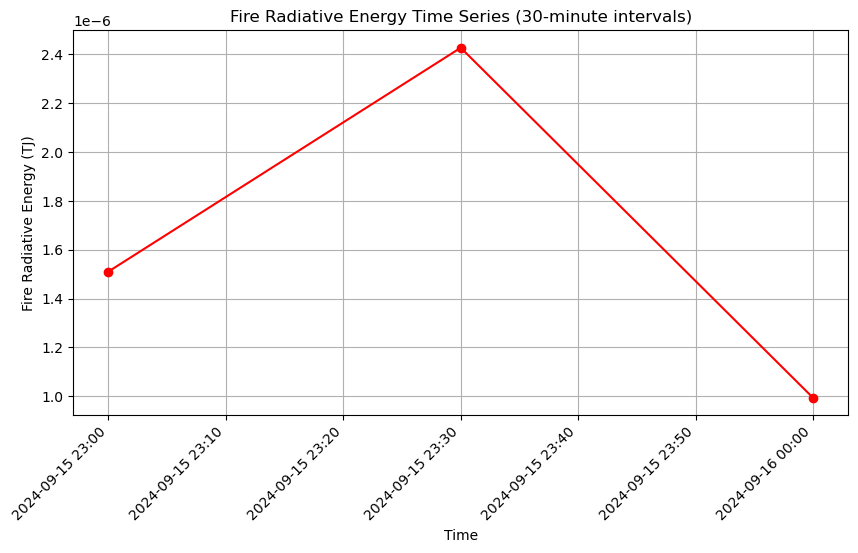

Processing new day: 2024-09-16
Processing slot 2024-09-16 00:15:00, found 16 points.
Processing slot 2024-09-16 00:30:00, found 17 points.
Processing slot 2024-09-16 00:45:00, found 14 points.
Processing slot 2024-09-16 01:00:00, found 13 points.
Processing slot 2024-09-16 01:15:00, found 17 points.
Processing slot 2024-09-16 01:30:00, found 15 points.
Processing slot 2024-09-16 01:45:00, found 12 points.
Processing slot 2024-09-16 02:00:00, found 13 points.
Processing slot 2024-09-16 02:15:00, found 13 points.
Processing slot 2024-09-16 02:30:00, found 16 points.
Processing slot 2024-09-16 02:45:00, found 13 points.
Processing slot 2024-09-16 03:00:00, found 17 points.
Processing slot 2024-09-16 03:15:00, found 15 points.
Processing slot 2024-09-16 03:30:00, found 14 points.
Processing slot 2024-09-16 03:45:00, found 15 points.
Processing slot 2024-09-16 04:00:00, found 22 points.
Processing slot 2024-09-16 04:15:00, found 19 points.
Processing slot 2024-09-16 04:30:00, found 26 point

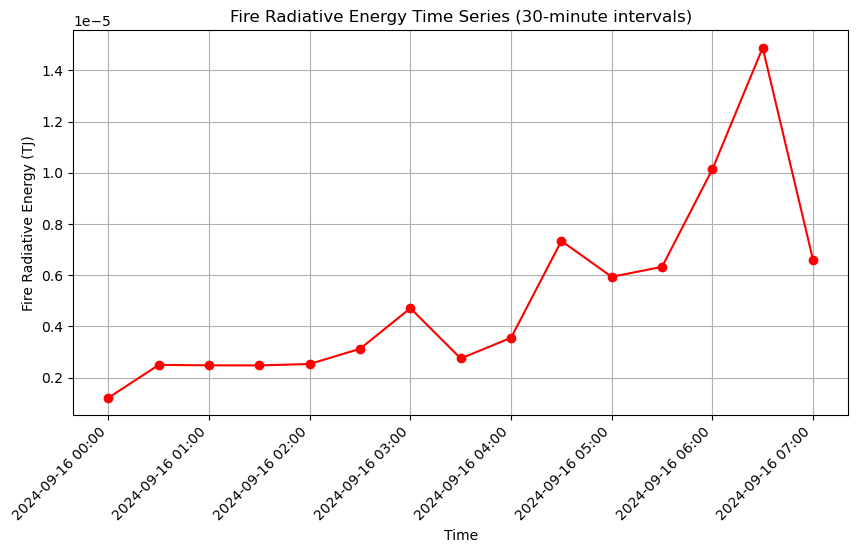

Finished processing all times


In [6]:
from msg_frppixel_script import main_lsasaf

start_time = "2024-09-15T23:00:00"  # should be a full 15-min time, like :00, :15, :30...
end_time = "2024-09-16T06:59:59"

main_lsasaf(start_time, end_time, lonlat_bbox, output_dir, run_name)